In [1]:
import numpy as np
from matplotlib import pyplot as plt
import ligo_functions as ligo
import os
import json
from scipy.constants import c

In [2]:
direc='/Users/alexlaroche/Desktop/PHYS 512/psets/pset6/LOSC_Event_tutorial'

events=json.load(open(direc+'/BBH_events_v3.json','r'))

Hanford={}
Livingston={}

In [3]:
for event in events:
    
    # read data
    
    strain_H, time_H, chan_dict_H = ligo.read_file(direc+'/'+events[event]['fn_H1'])
    Hanford[event]={'strain':strain_H,'time':time_H,'chan_dict_H':chan_dict_H}
    strain_L, time_L, chan_dict_L = ligo.read_file(direc+'/'+events[event]['fn_L1'])
    Livingston[event]={'strain':strain_L,'time':time_L,'chan_dict_H':chan_dict_L}

(a) Noise Model

We will model the noise as the power spectrum of the strain, $NFT=|SFT|^2.$ We average over the noise with a roling window over the two nearest neighbours. We use the flat window function Jon wrote in class, which is a cosine whose maximum is broadened. The window function 'make_flat_window' can be found in ligo_functions.py. 

In [4]:
for event in events:
    
    # windows
    
    nH=len(Hanford[event]['strain'])
    H_window=ligo.make_flat_window(nH,nH//2)
    nL=len(Livingston[event]['strain'])
    L_window=ligo.make_flat_window(nL,nL//5)
    
    #compute SFT and NFT
    
    Hanford[event]['SFT']=np.fft.rfft(Hanford[event]['strain']*H_window)
    Hanford[event]['NFT']=np.abs(Hanford[event]['SFT'])**2
    
    Livingston[event]['SFT']=np.fft.rfft(Livingston[event]['strain']*L_window)
    Livingston[event]['NFT']=np.abs(Livingston[event]['SFT'])**2 
    
    # average the noise
    
    for i in range(10): 
        
        Hnft=Hanford[event]['NFT'] 
        Hanford[event]['NFT']=(Hnft+np.roll(Hnft,1)+np.roll(Hnft,-1))/3
        
        Lnft=Livingston[event]['NFT']
        Livingston[event]['NFT']=(Lnft+np.roll(Lnft,1)+np.roll(Lnft,-1))/3

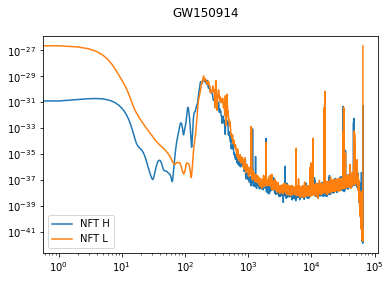

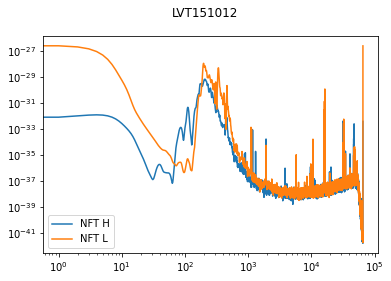

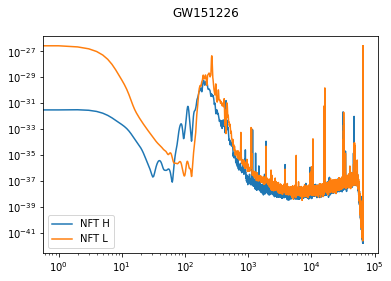

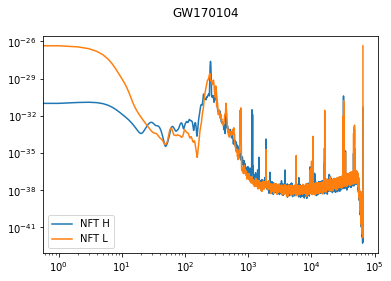

In [5]:
for event in events:
    
    #plot noise estimate for each event
    
    plt.loglog(Hanford[event]['NFT'],label='NFT H')
    plt.loglog(Livingston[event]['NFT'],label='NFT L')
    plt.suptitle(event)
    plt.legend()
    plt.show()

(b) Match Filter

We pre-whiten the strain and templates and compute the matched filters below.

In [6]:
for event in events:
    
    # templates
    
    Hanford[event]['template'],Livingston[event]['template']=ligo.read_template(direc+'/'+events[event]['fn_template'])
    Hanford[event]['TFT']=np.abs(np.fft.rfft(Hanford[event]['template']))
    Livingston[event]['TFT']=np.abs(np.fft.rfft(Livingston[event]['template']))
    
    # pre-whiten
    
    Hanford[event]['SFT_white']=Hanford[event]['SFT']/np.sqrt(Hanford[event]['NFT'])
    Hanford[event]['TFT_white']=np.fft.rfft(Hanford[event]['template']*H_window)/np.sqrt(Hanford[event]['NFT'])
    
    Livingston[event]['SFT_white']=Livingston[event]['SFT']/np.sqrt(Livingston[event]['NFT'])
    Livingston[event]['TFT_white']=np.fft.rfft(Livingston[event]['template']*L_window)/np.sqrt(Livingston[event]['NFT'])
    
    # matched filter
    
    Hanford[event]['MF']=np.fft.irfft(Hanford[event]['SFT_white']*np.conj(Hanford[event]['TFT_white']))
    Livingston[event]['MF']=np.fft.irfft(Livingston[event]['SFT_white']*np.conj(Livingston[event]['TFT_white']))

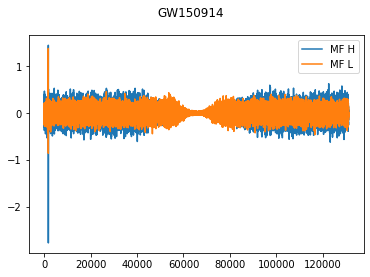

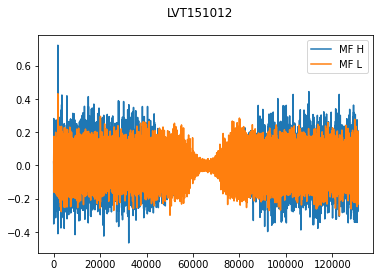

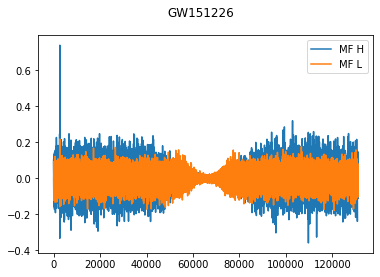

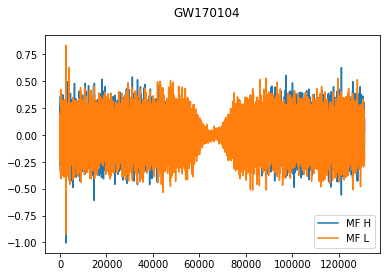

In [7]:
for event in events:
    
    #plot matched filter for each event
    
    plt.plot(Hanford[event]['MF'],label='MF H')
    plt.plot(Livingston[event]['MF'],label='MF L')
    plt.suptitle(event)
    plt.legend()
    plt.show()

(c) Signal-to-noise. 

We estimate the noise to be the standard deivation of the matched filter in a region over which the window function does not surpress the data. We combine the SNRs for Hanford and Livingston by adding in quadrature,
$SNR=\sqrt{SNR_H^2+SNR_L^2}.$

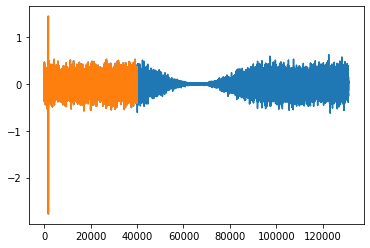

In [8]:
event='GW150914'
cut=40000
plt.plot(Hanford[event]['MF'])
plt.plot(Hanford[event]['MF'][:cut]) #region in which MF is unaffected by window
plt.show()

In [9]:
combined=events

for event in events:
        
    # Signal to noise, noise is std dev from orange interval above (obviously different for each dataset)
    
    Hanford[event]['SNR']=np.max(np.abs(Hanford[event]['MF']/np.std(Hanford[event]['MF'][:cut])))
    Livingston[event]['SNR']=np.max(np.abs(Livingston[event]['MF']/np.std(Livingston[event]['MF'][:cut])))
    
    # Combined SNR        
    
    combined[event]['SNR']=np.sqrt(Hanford[event]['SNR']**2+Livingston[event]['SNR']**2)

In [10]:
for event in events:
    # print 
    print(event,': Hanford SNR =',Hanford[event]['SNR'],', Livingston SNR =',Livingston[event]['SNR'],
         ' Combined SNR = ',combined[event]['SNR'],'\n')

GW150914 : Hanford SNR = 16.596370781319152 , Livingston SNR = 12.076090414934121  Combined SNR =  20.52489909404399 

LVT151012 : Hanford SNR = 6.495560580903638 , Livingston SNR = 5.503857852746564  Combined SNR =  8.513798125597601 

GW151226 : Hanford SNR = 9.802101541300503 , Livingston SNR = 5.148150531070853  Combined SNR =  11.071795180391065 

GW170104 : Hanford SNR = 7.3973819563911 , Livingston SNR = 6.692706952473353  Combined SNR =  9.97564966107099 



(d) Compare to analytic SNR

The analytic SNR is given by

$$ SNR_{analytic} = \max{\frac{MF}{\text{std}(IRFFT(TFT_\text{white}))}} $$

since the denominator is the standard deviation of the signal (template) relative to the noise model.




In [11]:
for event in events:
    
    Hanford[event]['SNR_A']=np.max(Hanford[event]['MF']/np.std(np.fft.irfft(Hanford[event]['TFT_white'])))
    Livingston[event]['SNR_A']=np.max(Livingston[event]['MF']/np.std(np.fft.irfft(Livingston[event]['TFT_white'])))
    combined[event]['SNR_A']=np.sqrt(Hanford[event]['SNR_A']**2+Livingston[event]['SNR_A']**2)
    
    print(event,':\n\n Hanford SNR analytic = ',Hanford[event]['SNR_A']
          ,', Livingston SNR analytic =',Livingston[event]['SNR_A']
          ,',\n Combined SNR analytic =',combined[event]['SNR_A'],'\n')

GW150914 :

 Hanford SNR analytic =  9.884138886611149 , Livingston SNR analytic = 12.382617526452607 ,
 Combined SNR analytic = 15.843781693024868 

LVT151012 :

 Hanford SNR analytic =  7.297506042473219 , Livingston SNR analytic = 5.574339776548422 ,
 Combined SNR analytic = 9.182965663898731 

GW151226 :

 Hanford SNR analytic =  10.916894809050602 , Livingston SNR analytic = 5.29021497702066 ,
 Combined SNR analytic = 12.131156860537649 

GW170104 :

 Hanford SNR analytic =  5.151226177281923 , Livingston SNR analytic = 6.220284600390975 ,
 Combined SNR analytic = 8.076327856109833 



The LVT151012, GW151226 and GW170104 estimated and analytic SNRs are in agreement with one another. These three events have combined estimated and analytic SNRs within $\sim1\sigma$ of each other.

The GW150914 is worse with $\sim5\sigma$ discrepancy between the combined SNRs and $\sim6\sigma$ discrepancy between the Hanford SNRs. In this case, the estimated SNR is much greater than the analyic SNR. This suggests that the noise computed from the matched filter is underestimated.

(e) Mid-point frequency

We may find the mid-point by taking the normed cummulative sum of the whitened template power and locating $k$ where the normed cumsum is 1/2. 

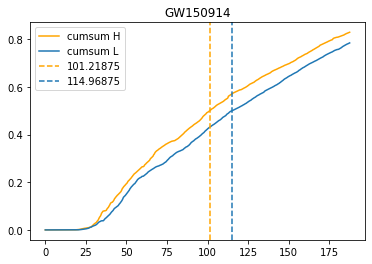

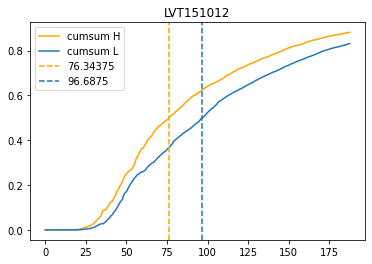

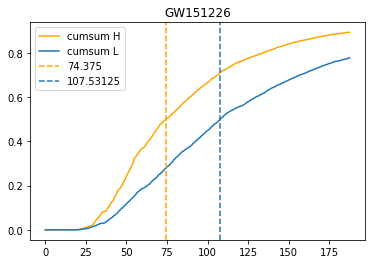

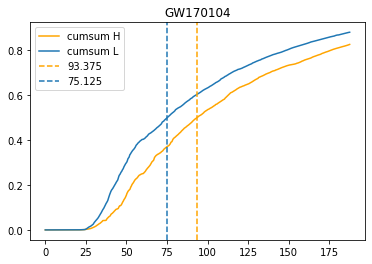

In [12]:
for event in events:
    
    #compute frequencies and cumsums of whitened TFT
    
    Hanford[event]['freqs']=np.fft.rfftfreq(len(Hanford[event]['template']),Hanford[event]['time'])
    power_H=np.abs(Hanford[event]['TFT_white'])**2
    Hanford[event]['TFT_white_cum']=np.cumsum(power_H)/np.sum(power_H)
    
    Livingston[event]['freqs']=np.fft.rfftfreq(len(Livingston[event]['template']),Livingston[event]['time'])
    power_L=np.abs(Livingston[event]['TFT_white'])**2
    Livingston[event]['TFT_white_cum']=np.cumsum(power_L)/np.sum(power_L)
    
    #find mid-point frequencies
    
    Hanford[event]['mid_freq']=Hanford[event]['freqs'][(np.abs(Hanford[event]['TFT_white_cum'] - 0.5)).argmin()]
    Livingston[event]['mid_freq']=Livingston[event]['freqs'][(np.abs(Livingston[event]['TFT_white_cum'] - 0.5)).argmin()]
    
    #plot mid-point frequencies along slices of cumsums
    
    cut=6000
    plt.plot(Hanford[event]['freqs'][:cut],Hanford[event]['TFT_white_cum'][:cut],label='cumsum H',color='orange') 
    plt.plot(Livingston[event]['freqs'][:cut],Livingston[event]['TFT_white_cum'][:cut],label='cumsum L') 
    plt.axvline(x=Hanford[event]['mid_freq'],label=Hanford[event]['mid_freq'],color='orange',ls='--')
    plt.axvline(x=Livingston[event]['mid_freq'],label=Livingston[event]['mid_freq'],ls='--')
    plt.title(event)
    plt.legend()
    plt.show()

The mid-point frequencies, in Hz, are given for both the Hanford and Livingston measurements in the above plots.

(f) Localize time of arrival

A schematic for the approach below can be found at https://web.njit.edu/~gary/728/Lecture6.html.

We will assume that the detectors are separated by a distance $B=2000$ km. The angular position of the event is then given by

$$ \theta = \sin^{-1}\left(\frac{\lambda}{B}\right), $$

where $\lambda=ct$ is the path length difference, $c$ is the speed of light and $t$ is the path time difference. If we assume that the uncertainty in time is the data time step of the detectors, $\delta t,$ the angular position uncertainty is 

$$ \delta \theta = \sin^{-1}\left(\frac{c\delta t}{B}\right). $$

In [14]:
B=2000 # distance between detectors in km

event='GW150914' # detectors have the same time step for all events so it does not matter which we choose
    
# combine time error for both detectors times speed of light to get path length error in km
cdt=(c/1e3)*np.sqrt(Hanford[event]['time']**2+Livingston[event]['time']**2)
    
dtheta=np.arcsin(cdt/B)*(180/np.pi) # calculate angular position error in degrees
    
print('Angular position uncertainty =',dtheta,'deg')

Angular position uncertainty = 2.9666236626537112 deg


The angular position uncertainty is roughly a few degrees.